In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import interpolate
import numpy as np
import pandas as pd
import json

from astropy.io import fits
import astropy.units as u
#from astropy.table import Table
#import itertools

Input path

observations folder location

In [3]:
text_file_0 = open("path-observations.txt", "r")
path_obs = text_file_0.read()

In [4]:
datapath_obs = Path(path_obs).expanduser()

results folder location

In [5]:
text_file_1 = open("path-results.txt", "r")
path_res = text_file_1.read()

In [6]:
datapath_res= Path(path_res).expanduser()

files names

In [7]:
data_file = 'TAURUS-604-Ha-'

In [8]:
name_export='TAU-N604-H'

In [9]:
flux_in = data_file + 'Flux.fits'
radial_velocity_in = data_file + 'RV.fits'
sigma_in = data_file + 'Sigma.fits'

In [10]:
flux=fits.open(datapath_obs / flux_in)
rad_vel=fits.open(datapath_obs / radial_velocity_in)
sigma=fits.open(datapath_obs / sigma_in)

Input data of the region

In [11]:
distance = 840000 #parsecs
pix = 0.26 #arcsec 
seeing = 0.9 #seeing arcsec FWHM

In [12]:
pc = distance*(2*np.pi) / (360 * 60 * 60) #arcsec to parsecs
s0 = (seeing*pc)/2.355 #seeing pc RMS
pc,s0

(4.072434921320102, 1.5563445559185105)

Flux map

Text(0.5, 1.0, 'H$_{α}$ Flux')

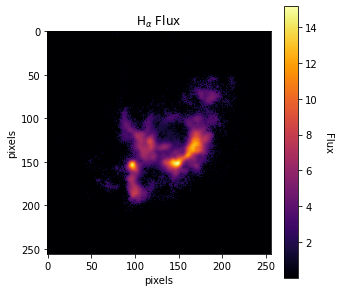

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

image_data=flux[0].data

plt.imshow(image_data, cmap='inferno')

ax.set_xlabel('pixels')
ax.set_ylabel('pixels')

cbar = plt.colorbar()
cbar.set_label('Flux', rotation=270, labelpad=15) 

plt.title('H$_{α}$ Flux')

Matrix to List

In [14]:
flx=flux[0].data
df=pd.DataFrame(flx)
dffx=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})
dffx.describe()

,X,Y,I
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,5.889378e-01
std,73.900834,73.900834,1.665959e+00
min,0.000000,0.000000,3.787646e-09
25%,63.750000,63.750000,3.787646e-09
50%,127.500000,127.500000,3.787646e-09
75%,191.250000,191.250000,3.787646e-09
max,255.000000,255.000000,1.515018e+01


Radial velocity map

Text(0.5, 1.0, 'H$_{α}$ Radial Velocity')

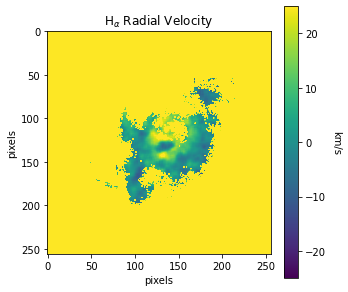

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

image_data=rad_vel[0].data

plt.imshow(image_data, cmap='viridis')

ax.set_xlabel('pixels')
ax.set_ylabel('pixels')

cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.clim(-25,25) 

plt.title('H$_{α}$ Radial Velocity')

Matrix to List

In [16]:
vel=rad_vel[0].data
df=pd.DataFrame(vel)
dfvr=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
dfvr.describe()

,X,Y,RV
count,65536.000000,65536.000000,65536.000000
mean,127.500000,127.500000,335.500406
std,73.900834,73.900834,139.319611
min,0.000000,0.000000,-16.693176
25%,63.750000,63.750000,393.980011
50%,127.500000,127.500000,393.980011
75%,191.250000,191.250000,393.980011
max,255.000000,255.000000,393.980011


Sigma map

Text(0.5, 1.0, 'H$_{α}$ σ$_{disp}$')

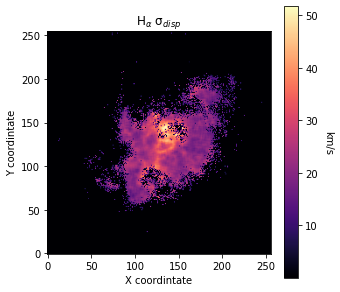

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

image_data=sigma[0].data

plt.imshow(image_data, cmap='magma')

ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')

cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  

plt.gca().invert_yaxis()
plt.title('H$_{α}$ σ$_{disp}$')

Matrix to list

In [18]:
sig=sigma[0].data
df=pd.DataFrame(sig)
df=df.reindex(index=df.index[::-1])
dsig=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'Sig'})
dsig.describe()

,X,Y,Sig
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,3.607881e+00
std,73.900834,73.900834,8.906863e+00
min,0.000000,0.000000,1.291134e-08
25%,63.750000,63.750000,1.291134e-08
50%,127.500000,127.500000,1.291134e-08
75%,191.250000,191.250000,1.291134e-08
max,255.000000,255.000000,5.164933e+01


Merge previous lists

In [19]:
data=dfvr
data['I']=dffx.I
data['Sig']=dsig.Sig
data.describe()

,X,Y,RV,I,Sig
count,65536.000000,65536.000000,65536.000000,6.553600e+04,6.553600e+04
mean,127.500000,127.500000,335.500406,5.889378e-01,3.607881e+00
std,73.900834,73.900834,139.319611,1.665959e+00,8.906863e+00
min,0.000000,0.000000,-16.693176,3.787646e-09,1.291134e-08
25%,63.750000,63.750000,393.980011,3.787646e-09,1.291134e-08
50%,127.500000,127.500000,393.980011,3.787646e-09,1.291134e-08
75%,191.250000,191.250000,393.980011,3.787646e-09,1.291134e-08
max,255.000000,255.000000,393.980011,1.515018e+01,5.164933e+01


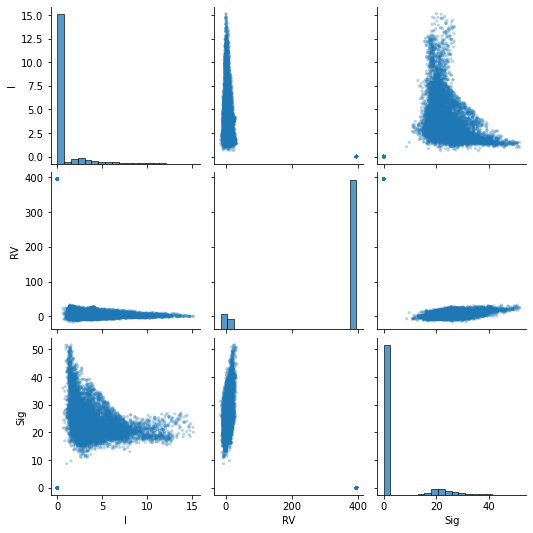

In [20]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

Clean data

In [21]:
mI=(data.I>data.I.mean()+0.5*data.I.std())&(data.Sig>data.Sig.mean()+0.5*data.Sig.std())
data=data[mI]

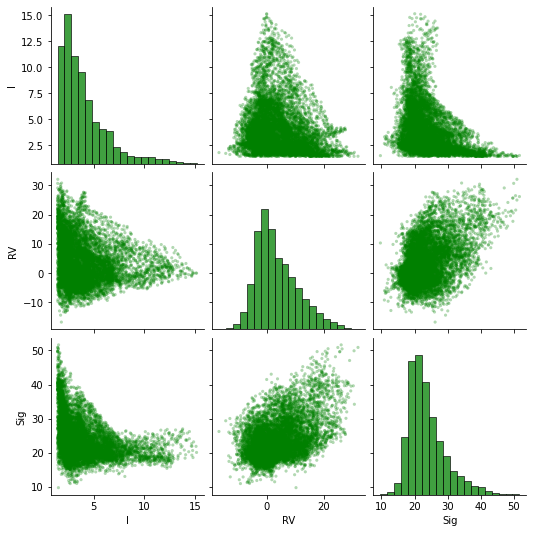

In [22]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none',color='green'),
             diag_kws=dict(bins=20, color="green"),
            )

In [23]:
data.describe()

,X,Y,RV,I,Sig
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,130.015247,138.798633,3.564254,4.017141,23.751665
std,33.245833,35.100884,7.391004,2.307828,5.653767
min,50.000000,45.000000,-16.693176,1.422287,9.705013
25%,106.000000,109.000000,-1.850128,2.393386,19.786402
50%,131.000000,139.000000,1.922028,3.357099,22.443563
75%,155.000000,169.000000,8.060150,4.908373,26.360056
max,206.000000,222.000000,32.009949,15.150179,51.649326


standars errors

In [24]:
data.sem()

X      0.340916
Y      0.359938
RV     0.075790
I      0.023665
Sig    0.057976
dtype: float64

Clean maps and other results

Text(0.5, 1.0, 'NGC 604')

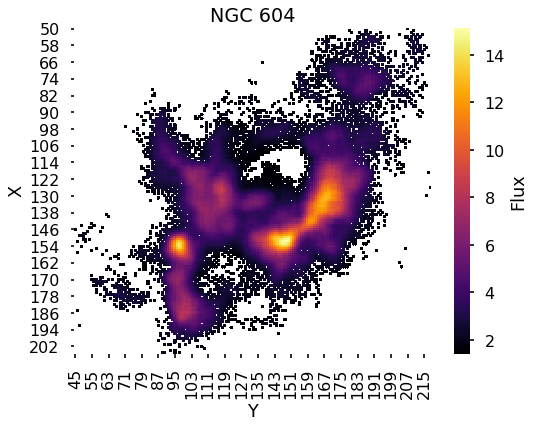

In [25]:
plt.style.use([
    "seaborn-poster",
])

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot()

datal=data.copy()
#datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
dataH_f=(datal.round(2)).pivot(index='X', columns='Y', values='I')
sns.heatmap(dataH_f, cmap="inferno",xticklabels='auto',cbar_kws={'label': 'Flux'})
#plt.title('H$_{α}$ Flux')
plt.title('NGC 604')

#plt.savefig('Imgs//Flux//N604.pdf', bbox_inches='tight')


In [26]:
#hdu = fits.ImageHDU(dataH_f)
#hdu.writeto(str(datapath_obs)+ '/' +data_file + 'Flux-mod.fits')

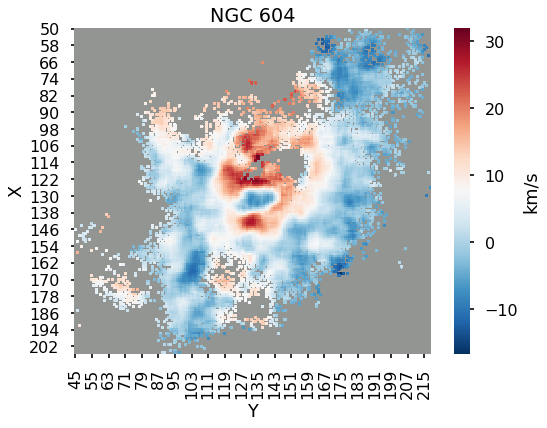

In [27]:
plt.style.use([
    "seaborn-poster",
])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

datal=data.copy()

dataH_rv=(datal.round(2)).pivot(index='X', columns='Y', values='RV')
sns.heatmap(dataH_rv, cmap="RdBu_r",cbar_kws={'label': 'km/s'})
plt.title('NGC 604')
ax.set_facecolor('xkcd:gray')

#plt.axhline(y=20, xmin=0.05, xmax=0.39, linewidth=2, color = 'k')

#ax.text(0.32, 0.9, '60 pc',
#        verticalalignment='bottom', horizontalalignment='right',
#        transform=ax.transAxes,
#        color='black', fontsize=20)

#plt.savefig('Imgs//VF//N604.pdf', bbox_inches='tight')


In [28]:
data_file

'TAURUS-604-Ha-'

In [29]:
#hdu = fits.PrimaryHDU(dataH_rv)
#hdu.writeto(str(datapath_obs)+ '/' +data_file + 'RV-mod.fits')

Text(0.5, 1.0, 'H$_{α}$ σ')

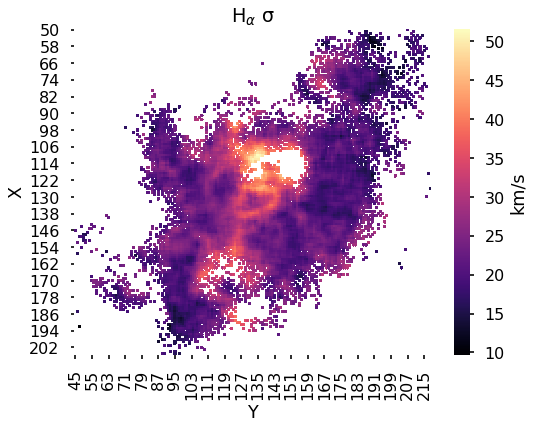

In [30]:
plt.style.use([
    "seaborn-poster",
])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

datal=data.copy()

dataH_s=(datal.round(2)).pivot(index='X', columns='Y', values='Sig')

sns.heatmap(dataH_s, cmap="magma",cbar_kws={'label': 'km/s'})
plt.title('H$_{α}$ σ')
#plt.savefig('TAURUS/Imgs/A/'+reg+'SH.png')

In [31]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU())
new_hdul.append(fits.ImageHDU(dataH_f))
new_hdul.append(fits.ImageHDU(dataH_rv))
new_hdul.append(fits.ImageHDU(dataH_s))

In [32]:
hdr = new_hdul[0].header

In [33]:
hdr ['CDELT1'] = (-pix / (60*60), '[deg] Coordinate increment at reference point')
hdr ['CDELT2'] = (pix / (60*60), '[deg] Coordinate increment at reference point')
hdr['CUNIT1']  = ('deg' , 'Units of coordinate increment and value' )      
hdr['CUNIT2']  = ('deg' , 'Units of coordinate increment and value'  )
hdr['CTYPE1']  = ('RA---CAR', 'Right ascension, plate caree projection  ')
hdr['CTYPE2']  = ('DEC--CAR', 'Declination, plate caree projection   ')
hdr['targname']  = ('NGC 604', 'Target name   ')
hdr['distance']  = (distance, 'Distance to target   ')
hdr['pix'] = (pix, 'arcsec.pixel^{-1}')

In [34]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CDELT1  = -7.2222222222222E-05 / [deg] Coordinate increment at reference point  
CDELT2  = 7.22222222222222E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg     '           / Units of coordinate increment and value        
CUNIT2  = 'deg     '           / Units of coordinate increment and value        
CTYPE1  = 'RA---CAR'           / Right ascension, plate caree projection        
CTYPE2  = 'DEC--CAR'           / Declination, plate caree projection            
TARGNAME= 'NGC 604 '           / Target name                                    
DISTANCE=               840000 / Distance to target                             
PIX     =                 0.

In [35]:
new_hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1                1 ImageHDU         7   (172, 156)   float64   
  2                1 ImageHDU         7   (172, 156)   float64   
  3                1 ImageHDU         7   (172, 156)   float64   


In [36]:
#new_hdul.writeto(str(datapath_obs)+ '/' +name_export + '-mod.fits')

Sigma disp - deconvolution

In [37]:
data['SigDisp']=(data.Sig**2-9.08**2-14.5**2)**0.5

<ipython-input-37-f66476a56c25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SigDisp']=(data.Sig**2-9.08**2-14.5**2)**0.5


In [38]:
data.describe()

,X,Y,RV,I,Sig,SigDisp
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9021.000000
mean,130.015247,138.798633,3.564254,4.017141,23.751665,16.210536
std,33.245833,35.100884,7.391004,2.307828,5.653767,7.698124
min,50.000000,45.000000,-16.693176,1.422287,9.705013,0.223411
25%,106.000000,109.000000,-1.850128,2.393386,19.786402,10.688729
50%,131.000000,139.000000,1.922028,3.357099,22.443563,15.026313
75%,155.000000,169.000000,8.060150,4.908373,26.360056,20.471407
max,206.000000,222.000000,32.009949,15.150179,51.649326,48.733526


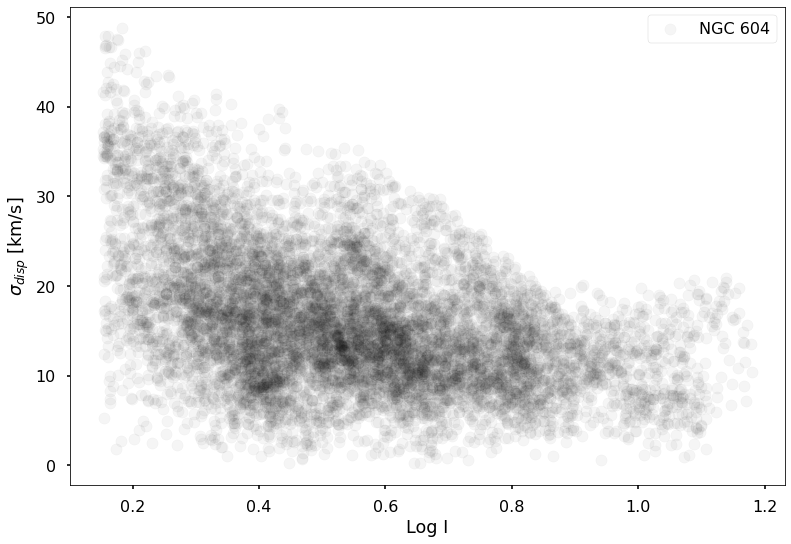

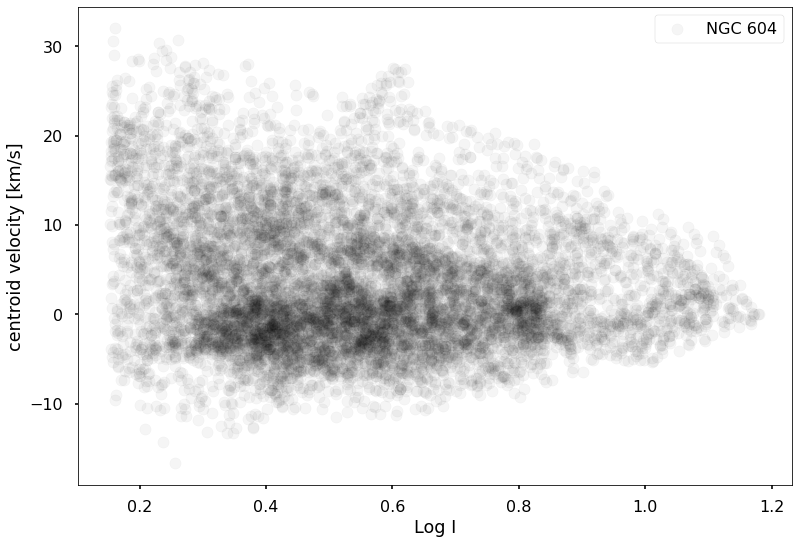

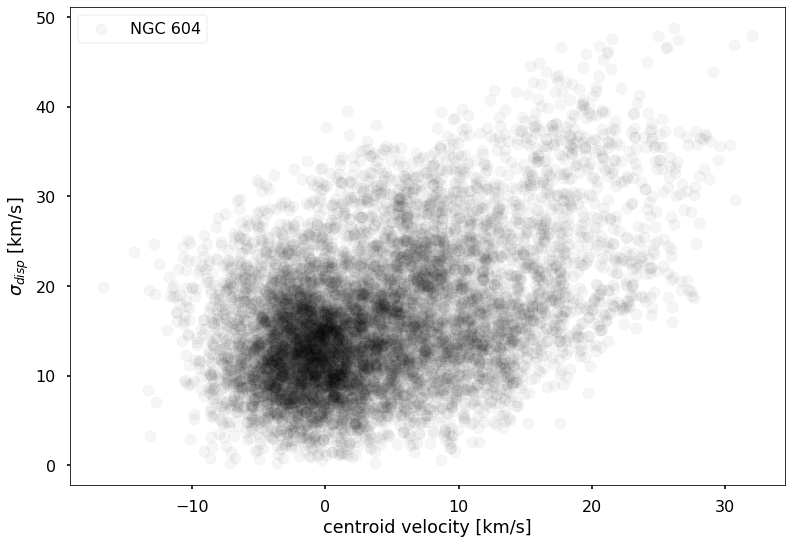

In [39]:
fig, ax = plt.subplots()
plt.scatter(np.log10(data.I),data.SigDisp, alpha=0.04, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(np.log10(data.I),data.RV, alpha=0.04, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('centroid velocity [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(data.RV,data.SigDisp, alpha=0.04, color='k',label='NGC 604')

ax.set_xlabel('centroid velocity [km/s]')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()



Text(0.5, 6.799999999999979, 'Radial velocity [km/s]')

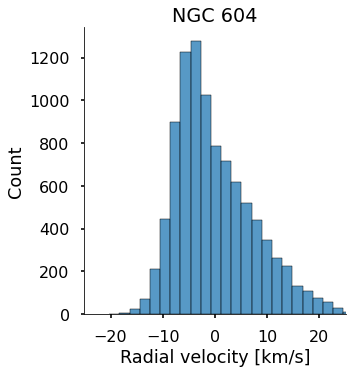

In [40]:
#fig, ax = plt.subplots()

sns.displot(data.RV-data.RV.mean(),bins=25)
plt.xlim(-25,25)

#plt.text(0.65, 1.20,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
#plt.text(0.70, 0.82,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
#plt.text(0.65, 1.3,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('NGC 604')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

plt.xlabel('Radial velocity [km/s]')

Export data

In [41]:
data_export_list = {
        'name': name_export, 
        'pc' : pc,
        's0' : s0,
        'pix' : pix,
         name_export : np.array(data),
      }
data_export_list

{'name': 'TAU-N604-H',
 'pc': 4.072434921320102,
 's0': 1.5563445559185105,
 'pix': 0.26,
 'TAU-N604-H': array([[ 50.        , 207.        ,  -3.27862542,   1.56147766,
          19.43360139,   9.21783396],
        [ 51.        , 179.        ,   0.33728034,   1.45873738,
          18.646513  ,   7.41593198],
        [ 51.        , 187.        ,   1.02920542,   2.02606583,
          15.56123067,          nan],
        ...,
        [206.        ,  90.        ,   2.39074719,   1.70957375,
          18.63963701,   7.39862607],
        [206.        ,  95.        ,  -4.05981432,   1.91255474,
          16.23114015,          nan],
        [206.        ,  97.        ,  -5.75619499,   1.80562449,
          15.25077821,          nan]])}

In [42]:
data_export_matrix = {
       'name': name_export, 
       'pc' : pc,
       's0' : s0,
       'pix' : pix,
       'sb' :np.array(dataH_f),
       'vv' : np.array(dataH_rv),
       'ss' : np.array(dataH_s),

      }

data_export_matrix

{'name': 'TAU-N604-H',
 'pc': 4.072434921320102,
 's0': 1.5563445559185105,
 'pix': 0.26,
 'sb': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'vv': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'ss': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])}

In [43]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [44]:
jsonfilename =name_export +"-m.json"
with open(datapath_res/jsonfilename, "w") as f:
    json.dump(data_export_matrix, fp=f, indent=3, cls=MyEncoder)

In [45]:
jsonfilename =name_export +"-l.json"
with open(datapath_res/jsonfilename, "w") as f:
    json.dump(data_export_list, fp=f, indent=3, cls=MyEncoder)

In [46]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 16.401854038238525 seconds ---


In [47]:
!jupyter nbconvert --to script --no-prompt otv-TAU-N604-H.ipynb

[NbConvertApp] Converting notebook otv-TAU-N604-H.ipynb to script
[NbConvertApp] Writing 8314 bytes to otv-TAU-N604-H.py
